# Capstone Project: Customer Segmentation Report for Arvato Financial Services

In this report, supervised and unsupervised learning techniques will be used to analyze demographics data for customers of a mail-order company in Germany against demographics information of the existing clients. Therefore, the research question that arises is:

* What are the potential customers and how can the company acquire them efficiently?

The main purpose of this project is to identify the right people, who can be potential customers. It will increase the efficiency of the customer acquisition process, by targeting the proper clients.

Unsupervised learning techniques will be used to perform customer segmentation. Then, supervised learning techniques will be used to predict which individuals are most likely to convert into becoming customers for the company. The data source has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

## Table of Contents

[Part 0: Get-to-Know-the-Data](#Get-to-Know-the-Data)<br>
[Part 1: Customer Segmentation Report](#part1)<br>
[Part 2: Supervised Learning Model](#part2)<br>
[Part 3: Kaggle Competition](#part3)<br>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
import progressbar
import pickle

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.preprocessing import RobustScaler, Imputer

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

%matplotlib inline

C:\Users\Desared\Anaconda3\lib\site-packages\xgboost\__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


## <a class="anchor" id="Get-to-Know-the-Data">Part 0: Get to Know the Data</a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 221 persons (rows) x 366 features (columns). Some of the feature values are missing. The data types are categorical, binary, ordinal and numerical. 
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns). Compared to the general population dataset, 3 more features are added in this dataset: CustomerGroup, OnlinePurchase, and ProductGroup. 
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns). Compared to the general population dataset, the information about the reaction to the mailout campaign is added.
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).  

For more information about the columns depicted in the files, I will refer to two Excel spreadsheets provided in the workspace.
- `DIAS Information Levels.xlsx`: a top-level list of attributes and descriptions, organized by informational category.
- `DIAS Attributes.xlsx`: a detailed mapping of data values for each feature in alphabetical order.



In [2]:
# Load data
general_population = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

general_population.head()

C:\Users\Desared\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [3]:
# Data info
general_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
# Load in the customer demographics data.
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

customers.head()

C:\Users\Desared\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
# Data info
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


## <a class="anchor" id="part1">Part 1: Customer Segmentation Report</a>

Using unsupervised learning techniques, the relationship between the demographics of the company's existing customers and the general population of Germany will be described. The purpose of this section is to describe parts of the general population that are most likely to be part of the mail-order company's main customer base.

## 1 Preprocessing

### 1.1 Dealing with Missing Data


In [6]:
# Laod DIAS Attributes
dias_attributes = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=[0])
del dias_attributes['Unnamed: 0']

# Drop NaN attribute
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isnull()]

In [7]:
# Load in the feature summary file.
population_feature_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')
population_feature_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# population_feature_info info
population_feature_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
population_feature_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [10]:
# Load in the feature summary file.
features_information = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')
features_information.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
features_information.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [12]:
# Attributes described in population_feature_info
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isin(population_feature_info.attribute)]

dias_attributes.head()

,Attribute,Description,Value,Meaning
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months


In [13]:
# dias_attributes shape
dias_attributes.shape

(233, 4)

In [14]:
# dias_attributes Meaning counts
dias_attributes.Meaning.value_counts(dropna=False)

unknown                                             172
no transaction known                                 34
highest activity within the last 12 months           12
no transactions known                                10
no Online-transactions within the last 12 months      3
Universal                                             1
very low car quote                                    1
Name: Meaning, dtype: int64

In [15]:
# Investigate attribute with unknown Meaning
unknown_Meaning = dias_attributes[dias_attributes['Meaning'] == 'unknown']

# Keep only attribute of general_population
unknown_Meaning = unknown_Meaning[unknown_Meaning['Attribute'].isin(general_population.columns)]

# unknown_Meaning shape
unknown_Meaning.head()

,Attribute,Description,Value,Meaning
765,KBA05_ALTER1,share of car owners less than 31 years old,"-1, 9",unknown
771,KBA05_ALTER2,share of car owners inbetween 31 and 45 years ...,"-1, 9",unknown
777,KBA05_ALTER3,share of car owners inbetween 45 and 60 years ...,"-1, 9",unknown
783,KBA05_ALTER4,share of cars owners elder than 61 years,"-1, 9",unknown
790,KBA05_ANHANG,share of trailers in the microcell,"-1, 9",unknown


In [16]:
# Get first part of attribute
unknown_Meaning['Short_Attribute'] = unknown_Meaning.Attribute.apply(lambda x: x.split('_')[0])

In [17]:
unknown_Meaning.Short_Attribute.value_counts(dropna=False)

KBA13    106
KBA05     58
Name: Short_Attribute, dtype: int64

### Discussion

*From their description and values, KBA13 and KBA05 are ordinals variabeles*

In [18]:
unknown_Meaning['type'] = 'ordinal'

In [19]:
# Investigate attribute with no transaction known
no_transaction = dias_attributes[dias_attributes['Meaning'].isin(['no transaction known', 'no transactions known'])]

# Keep only attribute of general_population
no_transaction = no_transaction[no_transaction['Attribute'].isin(general_population.columns)]

# Get first part of attribute
no_transaction['Short_Attribute'] = no_transaction.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
no_transaction

,Attribute,Description,Value,Meaning,Short_Attribute
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known,D19
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known,D19
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known,D19
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known,D19
478,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known,D19
485,D19_TELKO_ANZ_24,transaction activity TELCO in the last 24 months,0,no transactions known,D19
546,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12...,0,no transactions known,D19
553,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24...,0,no transactions known,D19
617,D19_VERSI_ANZ_12,transaction activity INSURANCE in the last 12 ...,0,no transactions known,D19
624,D19_VERSI_ANZ_24,transaction activity INSURANCE in the last 24 ...,0,no transactions known,D19


### Discussion

*From their description and values, D19 are ordinals variables*

In [20]:
no_transaction['type'] = 'ordinal'

In [21]:
# Investigate the rest of attributes 
meaningful_dias_attributes = dias_attributes[~dias_attributes['Meaning'].isin(
    ['no transaction known','no transactions known','unknown']
)]

# Keep only attribute of general_population
meaningful_dias_attributes = meaningful_dias_attributes[meaningful_dias_attributes['Attribute'].isin(general_population.columns)]

# Get first part of attribute
meaningful_dias_attributes['Short_Attribute'] = meaningful_dias_attributes.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
meaningful_dias_attributes

,Attribute,Description,Value,Meaning,Short_Attribute
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
186,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
196,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
206,D19_BANKEN_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
319,D19_GESAMT_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
329,D19_GESAMT_OFFLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
339,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
349,D19_GESAMT_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
384,D19_KONSUMTYP,consumption type,1,Universal,D19
492,D19_TELKO_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19


### Discussion

*From their respective description, all attributes in meaningful_dias_attributes are ordinal except D19_KONSUMTYP which is categorical*

In [22]:
meaningful_dias_attributes['type'] = meaningful_dias_attributes.Attribute.apply(
    lambda x: 'categorical' if x=='D19_KONSUMTYP' else 'ordinal'
)

#### Convert Missing Value Codes to NaNs

In [23]:
# Make a dataframe of features proprieties
unknown_Meaning['missing_or_unknown'] = unknown_Meaning.Value.apply(lambda x: [str(k) for k in str(x).split(',')])

# Drop colums
unknown_Meaning.drop(['Description', 'Value', 'Meaning', 'Short_Attribute'], axis=1, inplace=True)

# Change columns name
unknown_Meaning.columns = ['attribute', 'type', 'missing_or_unknown']

unknown_Meaning.head()

,attribute,type,missing_or_unknown
765,KBA05_ALTER1,ordinal,"[-1, 9]"
771,KBA05_ALTER2,ordinal,"[-1, 9]"
777,KBA05_ALTER3,ordinal,"[-1, 9]"
783,KBA05_ALTER4,ordinal,"[-1, 9]"
790,KBA05_ANHANG,ordinal,"[-1, 9]"


In [24]:
# no_transaction
no_transaction['missing_or_unknown'] = no_transaction.Value.apply(lambda x: [str(x)])

# Drop colums
no_transaction.drop(['Description', 'Value', 'Meaning', 'Short_Attribute'], axis=1, inplace=True)

# Change columns name
no_transaction.columns = ['attribute', 'type', 'missing_or_unknown']

no_transaction.head()

,attribute,type,missing_or_unknown
138,D19_BANKEN_ANZ_12,ordinal,[0]
145,D19_BANKEN_ANZ_24,ordinal,[0]
305,D19_GESAMT_ANZ_12,ordinal,[0]
312,D19_GESAMT_ANZ_24,ordinal,[0]
478,D19_TELKO_ANZ_12,ordinal,[0]


In [25]:
meaningful_dias_attributes['missing_or_unknown'] = meaningful_dias_attributes.Value.apply(lambda x: [])

# Drop colums
meaningful_dias_attributes.drop(['Description', 'Value', 'Meaning', 'Short_Attribute'], axis=1, inplace=True)

# Change columns name
meaningful_dias_attributes.columns = ['attribute', 'type', 'missing_or_unknown']

meaningful_dias_attributes.head()

,attribute,type,missing_or_unknown
152,D19_BANKEN_DATUM,ordinal,[]
186,D19_BANKEN_OFFLINE_DATUM,ordinal,[]
196,D19_BANKEN_ONLINE_DATUM,ordinal,[]
206,D19_BANKEN_ONLINE_QUOTE_12,ordinal,[]
319,D19_GESAMT_DATUM,ordinal,[]


In [26]:
population_feature_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [27]:
# population_feature_info
population_feature_info['missing_or_unknown'] = population_feature_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

# Drop information_level 
population_feature_info.drop(['information_level'], axis=1, inplace=True)

population_feature_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [28]:
# Concat feat info
final_population_feature_info = pd.concat(
    [population_feature_info, meaningful_dias_attributes, no_transaction, unknown_Meaning], ignore_index=True
)

In [29]:
# Shape of final_population_feature_info
final_population_feature_info.shape

(276, 3)

In [30]:
# Columns without type
columns_no_type = general_population.columns[~general_population.columns.isin(final_population_feature_info.attribute)]

In [31]:
# Check object features
object_features = general_population[columns_no_type].select_dtypes(include=['object'])
object_features.head()

,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,NaN,NaN
1,NaN,1992-02-10 00:00:00
2,D19_UNBEKANNT,1992-02-12 00:00:00
3,D19_UNBEKANNT,1997-04-21 00:00:00
4,D19_SCHUHE,1992-02-12 00:00:00


In [32]:
describe_dataframe = general_population[columns_no_type].describe()
describe_dataframe

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,CJT_KATALOGNUTZER,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,8.912210e+05,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,817722.000000,798073.000000,886367.000000,...,793947.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,6.372630e+05,4.421928,11.745392,13.402658,14.476013,15.089627,13.700717,0.154018,7.599356,3.335264,...,2.539212,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,2.572735e+05,3.638805,4.097660,3.243300,2.712427,2.452932,5.079849,0.502389,14.332201,1.493633,...,0.754926,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,1.916530e+05,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,1.000000,8.000000,11.000000,13.000000,14.000000,11.000000,0.000000,1.000000,2.000000,...,2.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,6.372630e+05,3.000000,12.000000,14.000000,15.000000,15.000000,14.000000,0.000000,3.000000,4.000000,...,3.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,8.600680e+05,9.000000,15.000000,16.000000,17.000000,17.000000,17.000000,0.000000,9.000000,5.000000,...,3.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,1.082873e+06,9.000000,18.000000,18.000000,18.000000,18.000000,25.000000,11.000000,449.000000,5.000000,...,3.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [33]:
# Data information
dias_information = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
del dias_information['Unnamed: 0']
dias_information = dias_information[dias_information.Attribute.isin(columns_no_type)]

dias_information

,Information level,Attribute,Description,Additional notes
67,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN


In [34]:
# List of columns to drop
col_to_drop = list(object_features.columns)
col_to_drop

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

### Discussion

*D19_LETZTER_KAUF_BRANCHE  contains some variables names, and EINGEFUEGT_AM includes timestamps. Both are to be dropped.*

In [35]:
remaining_attribute_information = pd.DataFrame({'attribute': list(describe_dataframe.columns)})
remaining_attribute_information['type'] = 'numeric'
remaining_attribute_information['missing_or_unknown'] = remaining_attribute_information['type'].apply(lambda x: [])

remaining_attribute_information.head()

,attribute,type,missing_or_unknown
0,LNR,numeric,[]
1,AKT_DAT_KL,numeric,[]
2,ALTER_KIND1,numeric,[]
3,ALTER_KIND2,numeric,[]
4,ALTER_KIND3,numeric,[]


In [36]:
# Concat remaining_attribute_information and final_population_feature_info
final_population_feature_info = pd.concat([final_population_feature_info, remaining_attribute_information], ignore_index=True)

final_population_feature_info.shape

(364, 3)

#### Convert Missing Value Codes to NaNs

In [37]:
# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(final_population_feature_info['attribute'], final_population_feature_info['missing_or_unknown']):
    if len(missing_values) != 0:
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
                general_population.loc[general_population[attrib] == value, attrib] = np.nan

In [38]:
# Drop col_to_drop
general_population.drop(col_to_drop, axis=1, inplace=True)

# check shape
general_population.shape

(891221, 364)

#### Assess Missing Data in Each Column

In [39]:
# Missing Data in Each Column
count_nan = general_population.isnull().sum()/len(general_population)

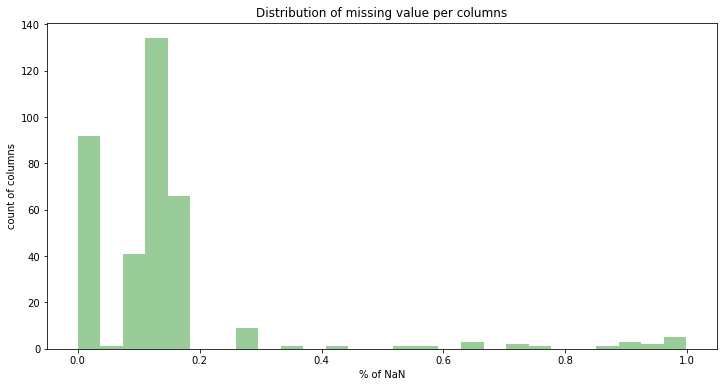

In [40]:
plt.figure(figsize=(12,6))
sns.distplot(count_nan.values, color="g", kde=False)
plt.ylabel('count of columns')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per columns')
plt.show()

### Discusion

*Most attributes contain less than 40% of missing values. Therefore I will drop all features that include more than 40% of missing values.*

In [41]:
# Get columns that have more than 40% of nan
missing_col = list(count_nan[count_nan > 0.4].index)
len(missing_col)

20

In [42]:
# Remove the outlier missing_col from the dataset.
general_population.drop(missing_col, axis=1, inplace=True)

general_population.shape

(891221, 344)

#### Assess Missing Data in Each row

In [43]:
# Missing Data in Each Column
row_nan = general_population.isnull().sum(axis=1)

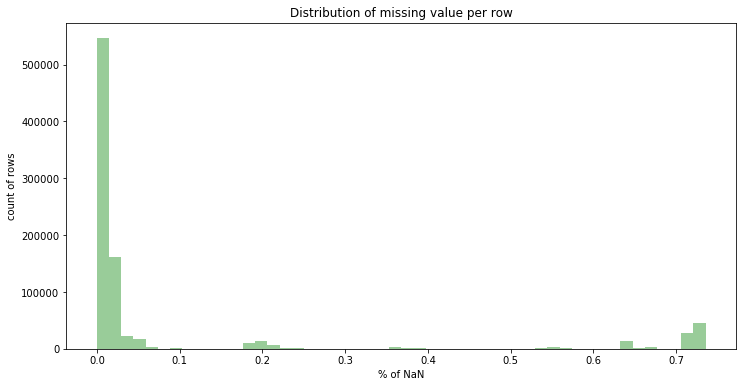

In [44]:
fig = plt.figure(figsize=(12,6))
sns.distplot(row_nan.values/344, color="g", kde=False)
plt.ylabel('count of rows')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per row')
plt.show()

### Discussion

*Rows that contain many missing values are harmful to machine learning algorithms. Therefore I will drop rows that contain more than 50% of missing values.*

In [45]:
# Drop row that contains more than 50% of nan values
general_population = general_population.loc[row_nan[row_nan <= 0.5 * 344].index]

general_population.reset_index(drop=True, inplace=True)

general_population.shape

(791987, 344)

In [46]:
general_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791987 entries, 0 to 791986
Columns: 344 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(288), int64(52), object(4)
memory usage: 2.0+ GB


### 1.2 Select and Re-Encode Features

Keep numeric, ordinal and interval data without changes. One-hot encode the categorical and feature engineer the mixed features.

In [47]:
final_population_feature_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [48]:
# keep only general_population attribute
final_population_feature_info = final_population_feature_info[final_population_feature_info.attribute.isin(
    general_population.columns
)]

len(final_population_feature_info)

344

In [49]:
count_type = final_population_feature_info.type.value_counts(dropna=False)
dataframe_count = pd.DataFrame(count_type.values, index=count_type.index, columns=['count columns'])
dataframe_count

,count columns
ordinal,229
numeric,89
categorical,19
mixed,6
interval,1


#### Re-Encode Categorical Features

For categorical data, depending on the number of categories,  I will perform one of the following:
-  For binary (two-level) categoricals that take numeric values, keep them without any change.
-  For binary variables that take on non-numeric values, re-encode the values as numbers.
- For multi-level categoricals variables (three or more values), re-encode the values using multiple dummies variables. 

In [50]:
final_population_feature_info.head()

,attribute,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]
5,FINANZ_SPARER,ordinal,[-1]


In [51]:
# Get list of Categorical Features
categorical_features = list(final_population_feature_info.attribute[final_population_feature_info.type == 'categorical'])

binary_num_attribute = []
binary_str_attribute = []
multi_level_attribute = []

for att in categorical_features:
    dtype = general_population[att].dtype
    count = len(general_population[att].value_counts())

    if count > 2:
        multi_level_attribute.append(att)
    else:
        if dtype == 'object':
            binary_str_attribute.append(att)
        else:
            binary_num_attribute.append(att)

In [52]:
# binary_num_attribute
binary_num_attribute

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [53]:
# binary_str_attribute
binary_str_attribute

['OST_WEST_KZ']

In [54]:
# multi_level_attribute
multi_level_attribute

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'D19_KONSUMTYP']

In [55]:
# Re-encode OST_WEST_KZ as dummy variable
general_population['OST_WEST_KZ'] = general_population['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [56]:
# Convert cat to cat to dummies variables
def encode_category(dataframe, list_cat):
    list_dataframe_dum = []
    for col_dum in list_cat:
        list_dataframe_dum.append(pd.get_dummies(dataframe[col_dum], prefix=col_dum))

    assert len(list_dataframe_dum) == len(list_cat)
    
    # Drop cat col from dataframe
    dataframe.drop(list_cat, axis=1, inplace=True)
    list_dataframe_dum.append(dataframe)
    dataframe = pd.concat(list_dataframe_dum, axis=1)

    return dataframe

In [57]:
final_general_population = encode_category(general_population, multi_level_attribute)

In [58]:
del general_population

### Engineer Mixed-Type Features

There are  six mixed features. Encode them as ordinal and dummies variables.

In [59]:
mixed_attributes = list(final_population_feature_info.attribute[final_population_feature_info.type == 'mixed'])
mixed_attributes

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

### Discussion

*"PRAEGENDE_JUGENDJAHRE" Combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.*

In [60]:
# Map decade
dic_dec = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}

# Map mouvement
dic_mov = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
           np.nan: np.nan, -1: np.nan, 0: np.nan}

final_general_population["PRAEGENDE_JUGENDJAHRE_dec"] = final_general_population["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)

# Mainstream : 0, Avantgarde : 1
final_general_population["PRAEGENDE_JUGENDJAHRE_mov"] = final_general_population["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)

# Drop PRAEGENDE_JUGENDJAHRE
final_general_population.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

### Discussion

*"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.*

In [61]:
def encode_CAMEO_INTL_2015(x):

    if np.isnan(x):
        return [np.nan, np.nan]
    else:
        x = str(x).split('.')[0]
        return [int(x[0]), int(x[1])]


final_general_population["CAMEO_INTL_2015"] = pd.to_numeric(final_general_population["CAMEO_INTL_2015"], errors='coerce') 
final_general_population["CAMEO_INTL_2015"] = final_general_population["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

# CAMEO_INTL_2015_wealth
final_general_population["CAMEO_INTL_2015_wealth"] = final_general_population["CAMEO_INTL_2015"].apply(lambda x: x[0])

# CAMEO_INTL_2015_life_stage
final_general_population["CAMEO_INTL_2015_life_stage"] = final_general_population["CAMEO_INTL_2015"].apply(lambda x: x[1])

# drop CAMEO_INTL_2015
final_general_population.drop('CAMEO_INTL_2015', axis=1, inplace=True)

### Discussion

*"LP_LEBENSPHASE_FEIN" contains information about life stage and fine scale. I will create two new ordinals features, one for life_stage and other for fine_scale*

In [62]:
life_stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

fine_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

final_general_population['LP_life_stage'] = final_general_population['LP_LEBENSPHASE_FEIN'].map(life_stage)
final_general_population['LP_fine_scale'] = final_general_population['LP_LEBENSPHASE_FEIN'].map(fine_scale)

# Drop LP_LEBENSPHASE_FEIN
final_general_population.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [63]:
# R-encode LP_life_stage and LP_fine_scale as ordinal
dictionary_life = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3, 'retirement_age': 4}
dictionary_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

final_general_population['LP_life_stage'] = final_general_population['LP_life_stage'].map(dictionary_life)
final_general_population['LP_fine_scale'] = final_general_population['LP_fine_scale'].map(dictionary_scale)

### Discussion

*LP_LEBENSPHASE_GROB contains the same information as LP_LEBENSPHASE_FEIN. Therefore I will drop it.*

In [64]:
final_general_population.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

### Discussion

*Re-encode WOHNLAGE  as dummies variables*

In [65]:
# replace 0 by nan
final_general_population['WOHNLAGE'] = final_general_population['WOHNLAGE'].replace(0, np.nan)

# Get dummumies variable
WOHNLAGE = pd.get_dummies(final_general_population['WOHNLAGE'], prefix='WOHNLAGE')

# Drop WOHNLAGE
final_general_population.drop('WOHNLAGE', axis=1, inplace=True)

# concat WOHNLAGE with final_general_population
final_general_population = pd.concat([final_general_population, WOHNLAGE], axis=1)

### Discussion

*I will Re-encode PLZ8_BAUMAX  as dummies variables*

In [66]:
# Get dummumies variable
PLZ8_BAUMAX = pd.get_dummies(final_general_population['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

# Drop PLZ8_BAUMAX
final_general_population.drop('PLZ8_BAUMAX', axis=1, inplace=True)

# concat WOHNLAGE with final_general_population
final_general_population = pd.concat([final_general_population, PLZ8_BAUMAX], axis=1)

### 1.3 Create a Cleaning Function


In [67]:
def clean_data(dataframe, drop_col=True, drop_row=True):
    """
    Perform feature engineering

    INPUT: demographics dataFrame
    OUTPUT: cleaned demographics dataframe
    """

    # Drop 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM'
    dataframe.drop(col_to_drop, axis=1, inplace=True)

    # convert missing value codes into NaNs
    for attrib, missing_values in zip(final_population_feature_info['attribute'], final_population_feature_info['missing_or_unknown']):
        if len(missing_values) != 0:
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                    dataframe.loc[dataframe[attrib] == value, attrib] = np.nan

    # remove selected columns
    if drop_col:
        dataframe.drop(missing_col, axis=1, inplace=True)
    
    # assessing missing value per row
    row_nan = dataframe.isnull().sum(axis=1)
    a = dataframe.shape[1]
    
    if drop_row:
        dataframe = dataframe.loc[row_nan[row_nan<=0.5*a].index]
        dataframe.reset_index(drop=True, inplace=True)

    # Re-encode OST_WEST_KZ as dummy variable
    dataframe['OST_WEST_KZ'] =  dataframe['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # Convert cat to cat to dummies variables
    dataframe = encode_category(dataframe, multi_level_attribute)
    
    # Mix
    dataframe["PRAEGENDE_JUGENDJAHRE_dec"] = dataframe["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)

    # Mainstream : 0, Avantgarde : 1
    dataframe["PRAEGENDE_JUGENDJAHRE_mov"] = dataframe["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)

    # Drop PRAEGENDE_JUGENDJAHRE
    dataframe.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # re
    # dataframe["CAMEO_INTL_2015"] = dataframe["CAMEO_INTL_2015"].astype('float')
    dataframe["CAMEO_INTL_2015"] = pd.to_numeric(dataframe["CAMEO_INTL_2015"], errors='coerce') 

    dataframe["CAMEO_INTL_2015"] = dataframe["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

    # CAMEO_INTL_2015_wealth
    dataframe["CAMEO_INTL_2015_wealth"] = dataframe["CAMEO_INTL_2015"].apply(lambda x: x[0])

    # CAMEO_INTL_2015_life_stage
    dataframe["CAMEO_INTL_2015_life_stage"] = dataframe["CAMEO_INTL_2015"].apply(lambda x: x[1])

    # drop CAMEO_INTL_2015
    dataframe.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #
    dataframe['LP_life_stage'] = dataframe['LP_LEBENSPHASE_FEIN'].map(life_stage)
    dataframe['LP_fine_scale'] = dataframe['LP_LEBENSPHASE_FEIN'].map(fine_scale)

    # Drop LP_LEBENSPHASE_FEIN 
    dataframe.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    dataframe['LP_life_stage'] = dataframe['LP_life_stage'].map(dictionary_life)
    dataframe['LP_fine_scale'] = dataframe['LP_fine_scale'].map(dictionary_scale)
    
    # Drop LP_LEBENSPHASE_GROB
    dataframe.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    # replace 0 by nan
    dataframe['WOHNLAGE'] = dataframe['WOHNLAGE'].replace(0, np.nan)

    # Get dummumies variable
    WOHNLAGE = pd.get_dummies(dataframe['WOHNLAGE'], prefix='WOHNLAGE')

    # Drop WOHNLAGE
    dataframe.drop('WOHNLAGE', axis=1, inplace=True)

    # concat WOHNLAGE with final_general_population
    dataframe = pd.concat([dataframe, WOHNLAGE], axis=1)
    
    # Get dummumies variable
    PLZ8_BAUMAX = pd.get_dummies(dataframe['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

    # Drop PLZ8_BAUMAX
    dataframe.drop('PLZ8_BAUMAX', axis=1, inplace=True)

    # concat WOHNLAGE with final_general_population
    dataframe = pd.concat([dataframe, PLZ8_BAUMAX], axis=1)
    
    return dataframe

## 2 Feature Transformation

### 2.1 Feature Scaling

### Discussion

*LNR is not useful for machine learning because it contains a unique value for each row. Therefore, it is to be dropped.*

In [68]:
# drop LNR from data to process
LNR_general_population = final_general_population['LNR']
final_general_population.drop('LNR', axis=1, inplace=True)

In [69]:
# Most of the variables in the data set are ordinal. Replace missing values in each variable by its median.
imputer_object = Imputer(missing_values=np.nan, strategy='median')
final_general_population = pd.DataFrame(
    imputer_object.fit_transform(final_general_population.values), columns=final_general_population.columns
)

In [70]:
# Check features range
describe_general_population = final_general_population.describe()
describe_general_population

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
count,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,...,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000,791987.000000
mean,0.116882,0.177696,0.184192,0.248111,0.139641,0.127535,0.247168,0.131176,0.053623,0.070257,...,0.313772,0.170908,0.093347,0.212928,0.020962,0.630613,0.088889,0.064052,0.071569,0.122883
std,0.321280,0.382257,0.387641,0.431917,0.346615,0.333571,0.431366,0.337593,0.225273,0.255581,...,0.464025,0.376429,0.290919,0.409377,0.143259,0.482639,0.284584,0.244845,0.257774,0.328303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Discussion

*Some features have a big range. I will scale the data to avoid  that some feature imbalance  weight*

In [71]:
# Apply feature scaling to the general population demographics data.
scaler = RobustScaler()
scaled_general_population = pd.DataFrame(scaler.fit_transform(final_general_population.values), columns=final_general_population.columns)

In [72]:
del describe_general_population

### 2.2 Dimensionality Reduction

Use [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.

In [73]:
# Apply PCA to the general_population data.
pca = PCA()
general_population_pca = pca.fit_transform(scaled_general_population)

In [74]:
def plot_pca(pca):
    '''
    Creates a plot associated with the principal components
    
    INPUT: pca - the result of instantian of PCA in scikit learn
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

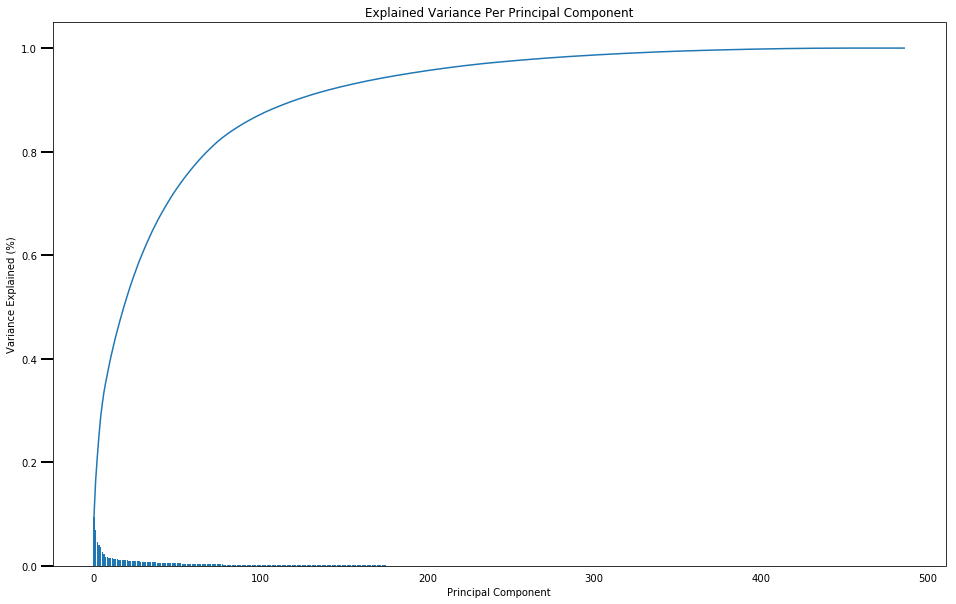

In [75]:
# Investigate the variance accounted for by each principal component.
plot_pca(pca)

### Discussion

*Looking at the plot above, we may notice that after 200 components the cumulative explained variance becomes superior to 0.95. So I will choose 200 features to re-do the PCA.*

In [76]:
# Re-apply PCA to the data whith 200 components.
pca = PCA(n_components=200)
general_population_pca = pca.fit_transform(scaled_general_population)

In [77]:
del scaled_general_population

len(general_population_pca)

791987

## 3 Clustering

### 3.1 Apply Clustering to General Population

*Let's perform k-means clustering on the PCA-transformed data. Before that, finding the most optimal number of clusters using the elbow method is necessary.*

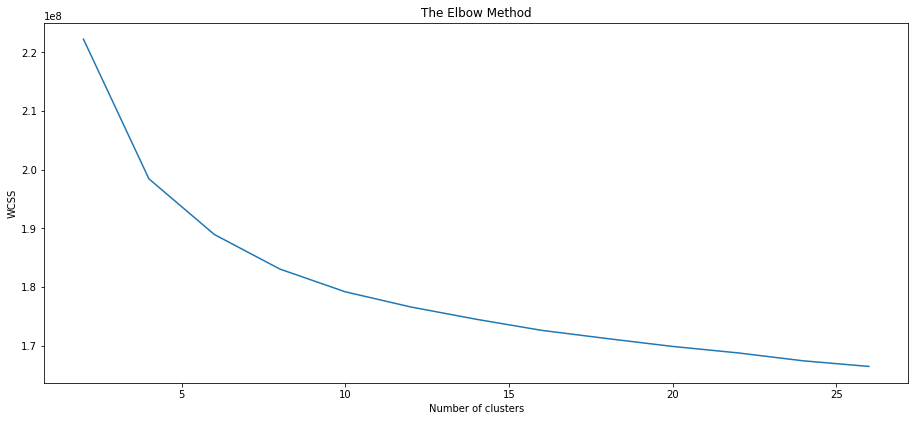

In [ ]:
# Elbow method
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
wcss = [] # within cluster sum of squares
for i in range(1, 27):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=77)
    kmeans.fit(general_population_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 27), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

### Discussion

*Looking at the plot above, we can notice that the score keeps decreasing and there is no visible elbow, but after 6 clusters the decrease is weaker. I will choose 6 clusters to do KMeans clustering.*

In [79]:
# Re-fit the k-means model with 6 class
kmeans = KMeans(n_clusters=6, random_state=77, n_jobs=-1)
labels_general_population = kmeans.fit_predict(general_population_pca)

In [80]:
class_count = pd.Series(labels_general_population).value_counts()

class_general_population = pd.DataFrame({'cluster': class_count.index,
                           '% of data': 100*class_count.values/len(labels_general_population)})
class_general_population['data'] = 'general population'

# print class_general_population
class_general_population

,% of data,cluster,data
0,37.463999,1,general population
1,31.231573,2,general population
2,19.139077,3,general population
3,5.323446,4,general population
4,4.974955,0,general population
5,1.866950,5,general population


### 3.2 Apply All Steps to the Customer Data

In [81]:
col_to_drop

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [82]:
# clean customer demographics data.
final_customers = clean_data(customers)

In [83]:
# Remove additional columns
sub_customers = final_customers[['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

final_customers.drop(['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

In [84]:
print('final_general_population shape', final_general_population.shape)
print('final_customers shape', final_customers.shape)

final_general_population shape (791987, 487)
final_customers shape (140899, 486)


In [85]:
#  Check for missing column in `final_customers`
mask = final_general_population.columns.isin(final_customers.columns)

miss_attribute = list(final_general_population.columns[~mask])
miss_attribute

['GEBAEUDETYP_5.0']

In [86]:
# Add the missing column with default value of 0
final_customers['GEBAEUDETYP_5.0'] = 0
final_customers['GEBAEUDETYP_5.0'] = final_customers['GEBAEUDETYP_5.0'].astype('uint8')

In [87]:
# replace missing value
final_customers = pd.DataFrame(imputer_object.transform(final_customers.values), columns=final_customers.columns)

In [88]:
# scale customers variables
final_customers = pd.DataFrame(scaler.transform(final_customers.values), columns=final_customers.columns)

In [89]:
# cluster predictions for the  customer demographics data.
customers_pca = pca.transform(final_customers)
labels_customers = kmeans.predict(customers_pca)

In [90]:
customer_class = pd.Series(labels_customers).value_counts()

class_customers = pd.DataFrame({'cluster': customer_class.index,
                              '% of data': 100*customer_class.values/len(labels_customers)})
class_customers['data'] = 'customers data'

# print class_general_population
class_customers

,% of data,cluster,data
0,99.982967,2,customers data
1,0.017033,5,customers data


### 3.3 Compare Customer Data to Demographics Data

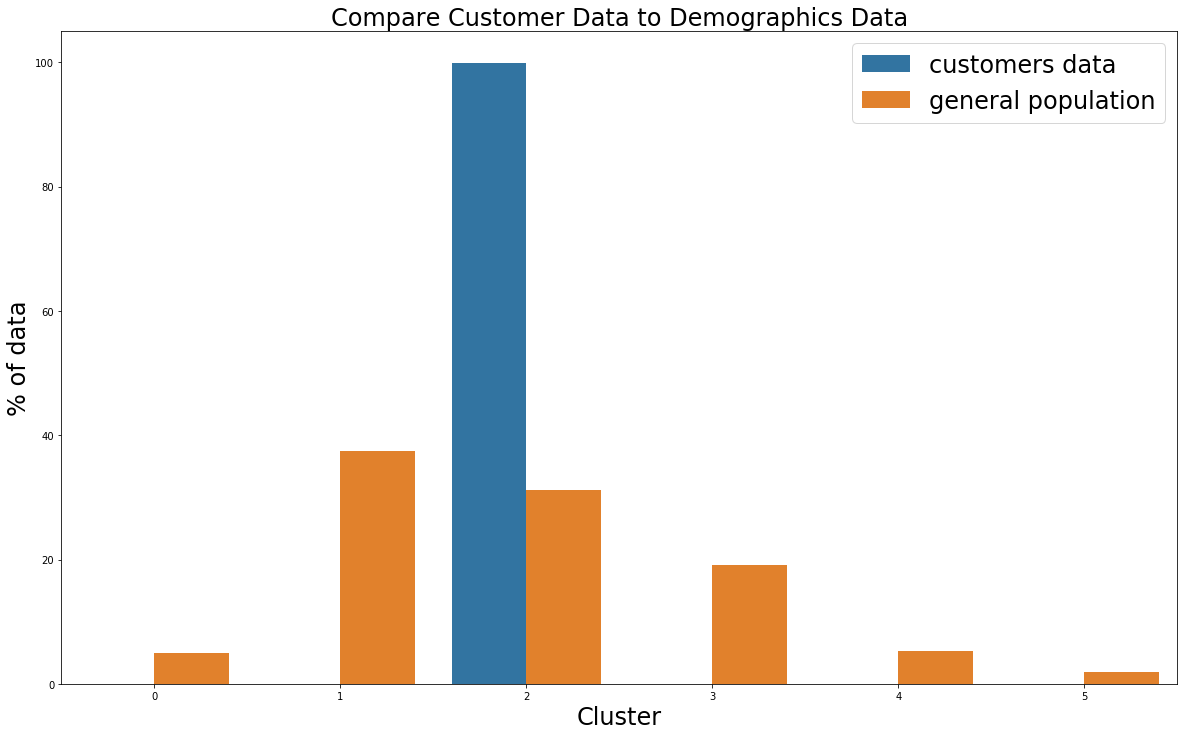

In [91]:
plt.figure(figsize=(20, 12))
sns.barplot(x="cluster", y="% of data", hue="data", data=pd.concat([class_customers, class_general_population]))
plt.xlabel('Cluster', fontsize=24)
plt.ylabel('% of data', fontsize=24)
plt.title('Compare Customer Data to Demographics Data', fontsize=24)
plt.legend(fontsize=24)
plt.show()

In [92]:
# Select peaple in the target class
target_class = [2]
target_pca = pca.inverse_transform(general_population_pca[np.isin(labels_general_population, target_class)])
target_general_population = scaler.inverse_transform(target_pca).round()
target_general_population = pd.DataFrame(target_general_population, columns=final_general_population.columns)

# Get LNR variable
target_LNR = LNR_general_population[np.isin(labels_general_population, target_class)]
target_general_population['LNR'] = target_LNR.values 

target_general_population.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,LNR
0,0.0,-0.0,0.0,-0.0,1.0,0.0,1.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,910220
1,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,645165
2,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,612569
3,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,612595
4,-0.0,0.0,0.0,1.0,0.0,-0.0,1.0,0.0,-0.0,0.0,...,1.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,612606


In [93]:
# Select peaple in the no target class
no_target_class = [0, 1, 3, 4, 5]
no_target_pca = pca.inverse_transform(general_population_pca[np.isin(labels_general_population, no_target_class)])
no_target_general_population = scaler.inverse_transform(no_target_pca).round()
no_target_pca = pd.DataFrame(no_target_pca, columns=final_general_population.columns)

# Get LNR variable
no_target_LNR = LNR_general_population[np.isin(labels_general_population, no_target_class)]
no_target_pca['LNR'] = no_target_LNR.values 
 
no_target_pca.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,LNR
0,0.108354,0.037554,0.772088,0.020228,0.050045,0.010659,0.771876,0.050819,0.000617,0.179881,...,0.350078,0.044997,0.078967,-0.007266,-0.133656,0.182491,-0.014470,-0.082201,0.025563,910225
1,-0.017635,0.480044,0.042315,0.093461,0.335777,0.059603,-0.033500,0.144079,0.104017,-0.065495,...,-0.178717,0.082810,0.715467,0.114456,-0.030490,-0.076874,0.157109,-0.072826,-0.042681,910226
2,0.186700,-0.201164,0.000088,0.064883,0.260122,0.683991,0.039269,0.159945,0.114539,0.120486,...,-0.282184,0.110480,0.152006,-0.000535,-0.756404,0.537992,0.081977,0.100082,-0.043229,910241
3,0.061191,0.797579,-0.103497,-0.145196,0.152596,0.230162,0.293805,0.744141,-0.105066,-0.028403,...,0.063130,0.121456,0.669385,0.055647,-0.174859,0.149558,0.001070,-0.034323,0.054049,910244
4,0.062671,0.224304,-0.020408,0.001354,0.288414,0.442890,0.704076,-0.086271,0.060228,0.208824,...,0.281395,0.220891,0.136674,-0.032907,-0.192925,0.339173,-0.017087,-0.071676,-0.040495,910248


### Conclusion

*99.9 % percent of the customers' data can be represented by cluster 2, which contain 31% of general_population data. *

##  <a class="anchor" id="part2">Part 2: Supervised Learning Model</a>

Now that I've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, I'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## 1 Exploring the Data

In [94]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

mailout_train.head()

C:\Users\Desared\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [95]:
# Data shape
mailout_train.shape

(42962, 367)

In [96]:
# Response values
cout = mailout_train.RESPONSE.value_counts(dropna=False)
customer_response = pd.DataFrame({'RESPONSE': cout.index, '% of data': cout.values})
customer_response['% of data'] = 100*customer_response['% of data']/42962

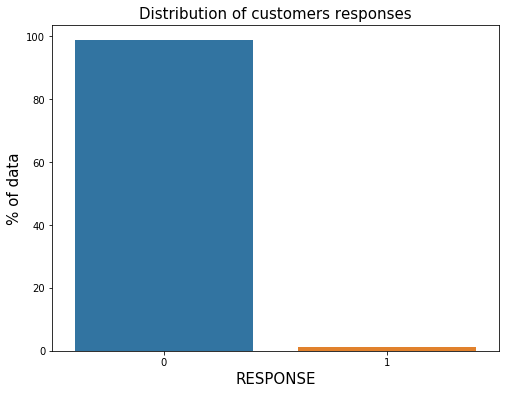

In [97]:
plt.figure(figsize=(8, 6))
sns.barplot(x="RESPONSE", y="% of data", data=customer_response)
matplotlib.rc('xtick', labelsize=25)  
matplotlib.rc('ytick', labelsize=25)
plt.xlabel('RESPONSE', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Distribution of customers responses', fontsize=15)
plt.show()

In [98]:
cout

0    42430
1      532
Name: RESPONSE, dtype: int64

### Discussion

*Out of all the 42 962 individuals in the mailout campaign, only 532 of the individuals became customers. The dataset is highly imbalanced.*

## 2 Preparing the Data

In [99]:
# Cleaning data
clean_mailout = clean_data(mailout_train)

In [100]:
# Response values
clean_mailout.RESPONSE.value_counts(dropna=False)

0    34663
1      437
Name: RESPONSE, dtype: int64

In [101]:
# Cheking missing values
sum_null = clean_mailout.isnull().sum(axis=1)

In [102]:
# Get LNR variable
mailout_LNR = clean_mailout['LNR'] 

# Drop LNR 
clean_mailout.drop('LNR', axis=1, inplace=True)

In [103]:
# Imputer
final_mailout = pd.DataFrame(imputer_object.fit_transform(clean_mailout.values), columns=clean_mailout.columns)

In [104]:
# feature scaling
final_mailout = pd.DataFrame(scaler.fit_transform(final_mailout.values), columns=final_mailout.columns)

In [105]:
final_mailout.shape

(35100, 487)

In [106]:
# split data to features and labels
response = final_mailout['RESPONSE']

# drop RESPONSE variable
features = final_mailout.drop('RESPONSE', axis=1)

## 3 Modeling the data 

#### Evaluating Model Performance

Use ROC-AUC to assess models performances since the data is highly imbalanced.

#### Supervised Learning Models
In this project, I will use the following four algorithms:

 - [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
 - [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
 - [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

In [107]:
# Initialize the four models
randomforest = RandomForestClassifier(random_state=11)
adaboost = AdaBoostClassifier(random_state=11) 
gradientboost = GradientBoostingClassifier(random_state=11)
xgboost = XGBClassifier(objective="binary:logistic", random_state=11)

In [108]:
# randomize the data
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation, :]
    Y2 = Y[permutation]
    
    return X2, Y2

X_train, y_train = randomize(np.asarray(features), np.asarray(response))

In [109]:
# Learning Curves
def draw_learning_curves(X, y, estimator, title="Learning Curves"):
    
    X2, y2 = randomize(X, y)
    
    train_sizes = np.linspace(.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X2,
        y2,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        train_sizes=train_sizes,
        shuffle=True,
        verbose=10
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    plt.grid()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Auc score")

    plt.plot(train_scores_mean, 'o-', color="b", label="Training score")
    plt.plot(test_scores_mean, 'o-', color="r", label="Cross-validation score")

    plt.legend(loc="best")

    plt.show()

[learning_curve] Training set sizes: [ 2807  5615  8423 11231 14039 16847 19655 22463 25271 28079]


[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    2.5s remaining:   40.1s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    5.0s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    6.7s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    8.0s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    9.6s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   11.5s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   12.9s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   14.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.0s finished


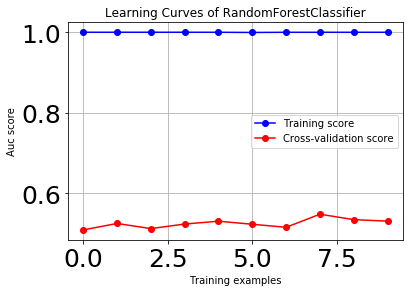

In [110]:
# RandomForestClassifier
draw_learning_curves(X_train, y_train, randomforest, title="Learning Curves of RandomForestClassifier")

[learning_curve] Training set sizes: [ 2807  5615  8423 11231 14039 16847 19655 22463 25271 28079]


[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   11.5s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   27.6s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   47.5s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  1.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  1.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  1.8min remaining:   55.6s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  2.0min remaining:   34.4s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  2.4min remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


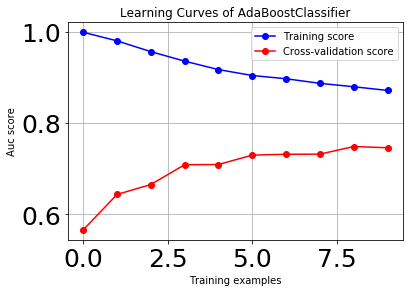

In [111]:
# AdaBoostClassifier
draw_learning_curves(X_train, y_train, adaboost, title="Learning Curves of AdaBoostClassifier")

[learning_curve] Training set sizes: [ 2807  5615  8423 11231 14039 16847 19655 22463 25271 28079]


[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   52.6s remaining: 13.8min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  2.3min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  3.9min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  5.6min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  7.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  8.7min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 10.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 12.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.6min finished


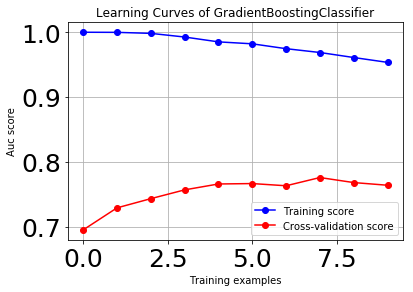

In [112]:
# GradientBoostingClassifier
draw_learning_curves(X_train, y_train, gradientboost, title="Learning Curves of GradientBoostingClassifier")

[learning_curve] Training set sizes: [ 2807  5615  8423 11231 14039 16847 19655 22463 25271 28079]


[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   54.1s remaining: 14.2min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  3.2min remaining: 14.6min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  4.6min remaining: 10.8min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  6.2min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  7.9min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  9.4min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 10.9min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 12.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.3min finished


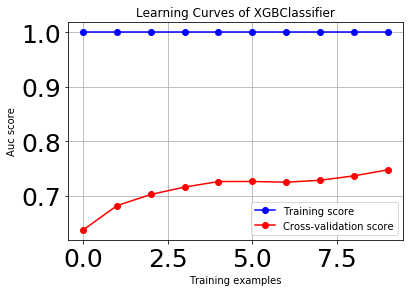

In [113]:
# XGBClassifier
draw_learning_curves(X_train, y_train, xgboost, title="Learning Curves of XGBClassifier")

### Conclusion 

For GradientBoosting, the training score remains pretty high and keeps decreasing, while the testing score keeps increasing. 

While for the XGBoost and RandomForest, the training score remains constant at a high level and the cross-validation score is low. This is a sign of these two models overfitting the data. In case of AdaBoost, the training score is lower compared to the other models.

The most performant model is GradientBoosting.

## 4 Parameter Tuning

#### Parameters to tune:
 - learning_rate: learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
 - n_estimators: The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
 - max_depth: maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.
 - min_samples_split: The minimum number of samples required to split an internal node.

For more information: [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [114]:
# Make predictions using unoptimized model
gradientboost_default_model = gradientboost.fit(X_train, y_train)
predictions = gradientboost_default_model.predict_proba(X_train)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y_train, predictions)))

Roc_auc score on training data: 0.9350


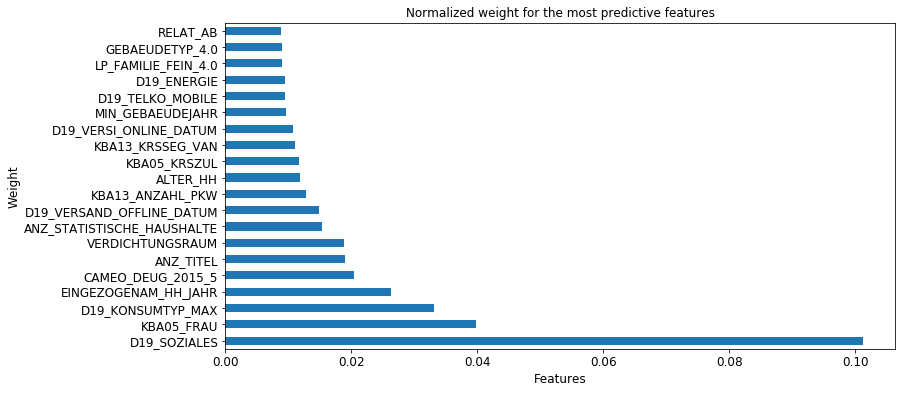

In [116]:
# feature importance
feature_importance = pd.Series(
    gradientboost_default_model.feature_importances_,
    index=features.columns
).sort_values(ascending=False)

# plot 20 important features
fig = plt.figure(figsize=(12, 6))
feature_importance.iloc[:20].plot(kind='barh')
matplotlib.rc('xtick', labelsize=12)  
matplotlib.rc('ytick', labelsize=12)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.title('Normalized weight for the most predictive features', fontsize=12)
plt.show()

In [118]:
# Tune the GradientBoostingClassifier

parameters = {
    'learning_rate': [0.05, 0.1], 
    'n_estimators': [100, 500], 
    'max_depth': [3, 5], 
    'min_samples_split': [2, 4] 
}
        
grid_object = GridSearchCV(gradientboost, parameters, scoring = 'roc_auc')

# Fit the grid search object to the training data and find the optimal parameters
grid_object.fit(X_train, y_train)

# Get the estimator and predict
print(grid_object.best_params_)

{'learning_rate': 0.05, 'min_samples_split': 2, 'max_depth': 3, 'n_estimators': 100}


In [134]:
best_model = grid_object.best_estimator_
# Make predictions using the best model
best_predictions = best_model.predict_proba(X_train)[:, 1]

print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

Final Roc_auc score on the training data: 0.9815


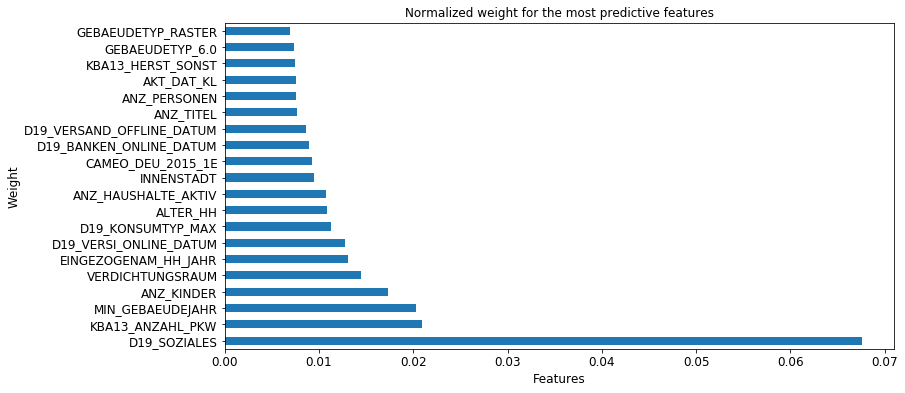

In [135]:
# feature importance
feature_importance = pd.Series(
    best_model.feature_importances_,
    index=features.columns
).sort_values(ascending=False)

# plot 20 important features
fig = plt.figure(figsize=(12, 6))
feature_importance.iloc[:20].plot(kind='barh')
matplotlib.rc('xtick', labelsize=12)  
matplotlib.rc('ytick', labelsize=12)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.title('Normalized weight for the most predictive features', fontsize=12)
plt.show()

##  <a class="anchor" id="part3">Part 3: Kaggle Competition</a>

Let's submit the test results to [Kaggle](https://www.kaggle.com/c/udacity-arvato-identify-customers) 

In [136]:
# Load data
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head()

C:\Users\Desared\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [137]:
# Clean data
clean_test = clean_data(mailout_test, drop_row=False)

In [138]:
# Drop LNR
test_LNR = clean_test['LNR']

clean_test.drop('LNR', axis=1, inplace=True)

In [139]:
# Imputer
final_test = pd.DataFrame(imputer_object.fit_transform(clean_test.values),
                        columns= clean_test.columns)

# feature scaling
final_test = pd.DataFrame(scaler.fit_transform(final_test.values),
                        columns= final_test.columns)

final_test.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
final_test.shape

(42833, 486)

In [141]:
# Prediction
test_label = best_model.predict_proba(final_test)[:,1]

submission = pd.DataFrame(test_label, index=test_LNR.astype('int32'), columns=["RESPONSE"])

submission.head()

,RESPONSE
LNR,
1754,0.043272
1770,0.035716
1465,0.005957
1470,0.003560
1478,0.005013


In [142]:
# Save file to submit
submission.to_csv('submission.csv')